### Activity 7.01: Implementing a DCGAN for the MNIST Fashion Dataset
The objective of this activity is to build a GAN and generate images similar to the fashion dataset. The high-level steps for this activity will be similar to Exercise 7.05, Implementing the DCGAN, where you implemented a DCGAN for handwritten digits. You will be completing this activity in two parts, first by creating the relevant functions and then by training the model.

In [1]:
# Required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam

In [2]:
# Function to generate real data samples
def realData(batch):
    # Get MNIST data
    (X_train, _), (_, _) = fashion_mnist.load_data()
    # Reshaping the input data to include channel
    X = X_train[:,:,:,np.newaxis]
    # Normalizing the data
    X = (X.astype('float32') - 127.5)/127.5
    # Generating a batch of data
    imageBatch = X[np.random.randint(0, X.shape[0], size=batch)] # np.random.randint(start,end,number-of-samples-to-generate)
    return imageBatch

In [3]:
# Generating a batch of images
mnistData = realData(25)

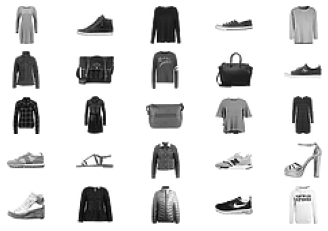

In [4]:
# Plotting the image
for j in range(5*5):
    pyplot.subplot(5,5,j+1)
    # Turn off axis
    pyplot.axis('off')
    pyplot.imshow(mnistData[j,:,:,0], cmap='gray_r')

In [5]:
# Function to generate inputs for generator function
def fakeInputs(batch, infeats):
    # Generate random noise data with shape (batch, input features)
    x_fake = np.random.uniform(-1, 1, size=[batch,infeats])
    return x_fake

In [6]:
# Function for the generator model
def genModel(infeats):
    # Defining the Generator model
    Genmodel = Sequential()
    Genmodel.add(Dense(512,input_dim=infeats))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    # Second layer of FC => RElu => BN layers
    Genmodel.add(Dense(7*7*64))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    # Upsample to 14 x 14
    Genmodel.add(Reshape((7,7,64)))
    Genmodel.add(Conv2DTranspose(32,kernel_size=(5,5),strides=(2,2),padding='same'))
    Genmodel.add(Activation('relu'))
    Genmodel.add(BatchNormalization())
    # Upsample to 28 x 28
    Genmodel.add(Conv2DTranspose(1,kernel_size=(5,5),strides=(2,2),padding='same'))
    Genmodel.add(Activation('tanh'))
    return Genmodel

In [7]:
# Function to create fake samples using the generator model
def fakedataGenerator(Genmodel,batch,infeats):
    # Generate inputs to the model
    genInputs = fakeInputs(batch,infeats)
    # Use inputs inside generator model to generate fake distribution
    X_fake = Genmodel.predict(genInputs)
    return X_fake

In [8]:
# Define the arguments like batch size and input feature
batch = 128
infeats = 100
Genmodel = genModel(infeats)
Genmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3136)              1608768   
                                                                 
 activation_1 (Activation)   (None, 3136)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 3136)             12544     
 hNormalization)                                        

2022-07-30 08:46:07.878238: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Generating a fake sample and printing the shape
fake = fakedataGenerator(Genmodel, batch, infeats)
fake.shape

(128, 28, 28, 1)

Text(0.5, 0, 'Fake Sample Image')

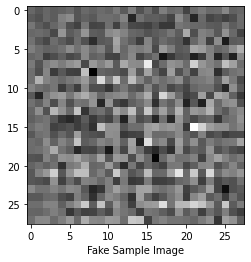

In [10]:
# Plotting the fake sample
plt.imshow(fake[1, :, :, 0], cmap='gray_r')
plt.xlabel('Fake Sample Image')

In [11]:
# Descriminator model as a function
def discModel():
    Discmodel = Sequential()
    Discmodel.add(Conv2D(32,kernel_size=(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
    Discmodel.add(LeakyReLU(0.2))
    # Second layer of convolutions
    Discmodel.add(Conv2D(64,kernel_size=(5,5),strides=(2,2),padding='same'))
    Discmodel.add(LeakyReLU(0.2))
    # Fully connected layers
    Discmodel.add(Flatten())
    Discmodel.add(Dense(512))
    Discmodel.add(LeakyReLU(0.2))
    Discmodel.add(Dense(1,activation='sigmoid'))
    Discmodel.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.002,beta_1=0.5),metrics=['accuracy'])
    return Discmodel

In [12]:
# Print the summary of the discriminator model
Discmodel = discModel()
Discmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1606144   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)              

In [13]:
# Define the combined generator and discriminator model for updating the generator
def ganModel(Genmodel, Discmodel):
    # Discriminator cannot be trained
    Discmodel.trainable = False
    Ganmodel = Sequential()
    # Adding the generator model
    Ganmodel.add(Genmodel)
    # Adding the discriminator without training the parameters
    Ganmodel.add(Discmodel)
    # Compile the model for loss to optimize the Generator model
    Ganmodel.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.002, beta_1=0.5))
    return Ganmodel

In [14]:
# Initialize the gan model
gan_model = ganModel(Genmodel, Discmodel)
# Print summary of Gan model
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         1727233   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1658753   
                                                                 
Total params: 3,385,986
Trainable params: 1,719,873
Non-trainable params: 1,666,113
_________________________________________________________________


In [16]:
# Defining the number of epochs
nEpochs = 5000

In [17]:
# Train the GAN network
for i in range(nEpochs):
    # Generate samples equal to the batch size from the real distribution
    x_real = realData(batch)
    # Generate fake samples using the fake data generator function
    x_fake = fakedataGenerator(Genmodel, batch, infeats)
    # Concatenating the real and fake data
    X = np.concatenate([x_real, x_fake])
    # Creating the dependent variable and initializing them as '0'
    Y = np.zeros(batch * 2)
    # Making the first set equal to batch with labels 1
    Y[:batch] = 1
    # Train the discriminator on the real samples
    discLoss = Discmodel.train_on_batch(X, Y)
    # Generate new fake inputs for training the GAN network
    x_gan = fakeInputs(batch*2, infeats)
    # Create labels of the fake examples as 1 to fool the discriminator
    y_gan = np.ones((batch*2, 1))
    # Update the generator model through the discriminator model
    gan_model.train_on_batch(x_gan, y_gan)
    # Print the accuracy measures on the real and fake data for every 10 epochs
    if (i) % 50 == 0:
        # Printing the discriminator loss and accuracy
        x_real_test = realData(10)
        x_fake_test = fakedataGenerator(Genmodel, 10, infeats)
        # Concatenating the real and fake data
        X_test = np.concatenate([x_real_test, x_fake_test])
        # Creating the dependent variable and initializing them as '0'
        Y = np.zeros(20 * 2)
        Y[:10] = 1
        # Predicting probabilities
        preds = Discmodel.predict(X_test)
        print('Discriminator probability:{D}'.format(D=np.mean(preds)))
        # Generate fake samples using fake data generator function
        x_fake = fakedataGenerator(Genmodel, batch, infeats)
        # Saving the plots
        for j in range(5*5):
            pyplot.subplot(5,5,j+1)
            # Turn off axis
            pyplot.axis('off')
            pyplot.imshow(x_fake[j, :, :, 0], cmap='gray_r')
        filename = 'fashion/GAN_MNIST_TRAINING_Plot%03d.png' % (i)
        pyplot.savefig(filename)
        pyplot.close()

Discriminator probability:0.7580185532569885
Discriminator probability:0.5000219345092773
Discriminator probability:0.5000206232070923
Discriminator probability:0.5000025629997253
Discriminator probability:0.3616485893726349
Discriminator probability:0.6427311301231384
Discriminator probability:0.3749217987060547
Discriminator probability:0.29386433959007263
Discriminator probability:0.585605263710022
Discriminator probability:0.4663378596305847
Discriminator probability:0.26752546429634094
Discriminator probability:0.6792841553688049
Discriminator probability:0.4981711506843567
Discriminator probability:0.548931360244751
Discriminator probability:0.451896607875824
Discriminator probability:0.502722978591919
Discriminator probability:0.4608938694000244
Discriminator probability:0.3638583719730377
Discriminator probability:0.5328571796417236
Discriminator probability:0.5793663859367371
Discriminator probability:0.36303916573524475
Discriminator probability:0.5599852800369263
Discriminat

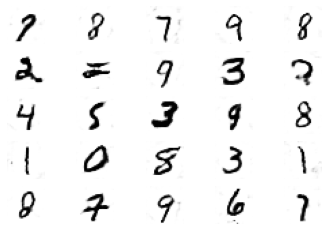

In [21]:
# Images predicted after training
x_fake = fakedataGenerator(Genmodel, 25, infeats)
# Visualizing the plots
for j in range(5*5):
    pyplot.subplot(5,5,j+1)
    # Turn off axis
    pyplot.axis('off')
    pyplot.imshow(x_fake[j, :, :, 0], cmap='gray_r')